In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys; sys.path.append('..')
import random, math
import pyzx as zx
from fractions import Fraction
from pyzx.phasepoly import circuit_phase_polynomial_blocks, optimize_block
%config InlineBackend.figure_format = 'svg'
zx.quantomatic.quantomatic_location = r'C:\Users\John\Desktop\scala.jar'

In [3]:
import os
import time

class CircuitComparer:
    def __init__(self, dirname, before, after):
        self.fname_before = os.path.join(dirname, before)
        if after:
            self.fname_after = os.path.join(dirname, after)
        else:
            self.fname_after = ""
        self.fname_tpar = ""
        if before.find('before') != -1:
            self.name = before[:-7]
        else:
            self.name = before
        self.has_run = False
    
    def __str__(self):
        return "CircuitComparer({}, {})".format(self.name, str(self.has_run))

    def __repr__(self):
        return str(self)
    
    def run(self):
        if self.has_run: return True
        #try: 
        if self.fname_after:
            c = zx.Circuit.from_quipper_file(self.fname_after).to_basic_gates()
            self.t_opt = c.tcount()
        else:
            self.t_opt = '-'
        c = zx.Circuit.load(self.fname_before).to_basic_gates()
        self.qubits = c.qubits
        #except TypeError: return False
        if self.fname_tpar:
            c2 = zx.Circuit.load(self.fname_tpar)
            self.tpar = c2.tcount()
        else: self.tpar = "-"
        self.gatecount = len(c.gates)
        self.t_before = c.tcount()
        g = c.to_graph()
        t = time.time()
        while True:
            zx.simplify.full_reduce(g)
            break
            m = zx.rules.match_gadgets_phasepoly(g)
            if not m: break
            zx.rules.apply_gadget_phasepoly(g, m)
        self.t_after = zx.tcount(g)
        self.time_simpl = time.time() - t
        t = time.time()
        self.extracts = True
        try: 
            c2 = zx.extract.streaming_extract(g,quiet=True)
            self.time_extr = time.time() - t
        except Exception:
            self.extracts = False
            self.time_extr = "-"
        self.has_run = True
        del c, g
        return True
    
    def pretty(self):
        if not self.has_run:
            success = self.run()
        else: success = True
        if not success: 
            return self.name + "    -"
        s = self.name.ljust(20) + str(self.qubits).rjust(7)
        s += str(self.gatecount).rjust(8) + str(self.t_before).rjust(9) + str(self.t_opt).rjust(10) 
        s += str(self.tpar).rjust(6) + str(self.t_after).rjust(7)
        s += "{:.2f}".format(self.time_simpl).rjust(12)
        s += "{:.2f}".format(self.time_extr).rjust(14)
        #s += ("y" if self.extracts else "n").rjust(7)
        return s

In [4]:

dirs = [r'..\circuits\Arithmetic_and_Toffoli', r'..\circuits\QFT_and_Adders', r'..\circuits\Other']
beforefiles = []
afterfiles = []
tparfiles = []
for d in dirs:
    for f in os.listdir(d):
        if not os.path.isfile(os.path.join(d,f)): continue
        if f.find('before') != -1:
            beforefiles.append((f,d))
        elif f.find('tpar') != -1:
            tparfiles.append((f,d))
        elif f.find('.qc') != -1 or f.find('.tfc') != -1:
            beforefiles.append((f,d))
        else: afterfiles.append((f,d))

circuits = []
for f, d in beforefiles:
    n = f[:-7]
    for f2,d2 in afterfiles:
        if d!=d2: continue
        if f2.startswith(n):
            c = CircuitComparer(d, f, f2)
            circuits.append(c)
            break
    else:
        c = CircuitComparer(d, f, '')
        circuits.append(c)
    for f2,d2 in tparfiles:
        if d!=d2: continue
        if f2.startswith(n):
            circuits[-1].fname_tpar = os.path.join(d2,f2)
circuits[:30]

[CircuitComparer(adder_8, False),
 CircuitComparer(barenco_tof_10, False),
 CircuitComparer(barenco_tof_3, False),
 CircuitComparer(barenco_tof_4, False),
 CircuitComparer(barenco_tof_5, False),
 CircuitComparer(csla_mux_3_original, False),
 CircuitComparer(csum_mux_9_corrected, False),
 CircuitComparer(gf2^10_mult, False),
 CircuitComparer(gf2^16_mult, False),
 CircuitComparer(gf2^4_mult, False),
 CircuitComparer(gf2^5_mult, False),
 CircuitComparer(gf2^6_mult, False),
 CircuitComparer(gf2^7_mult, False),
 CircuitComparer(gf2^8_mult, False),
 CircuitComparer(gf2^9_mult, False),
 CircuitComparer(mod5_4, False),
 CircuitComparer(mod_adder_1024, False),
 CircuitComparer(mod_mult_55, False),
 CircuitComparer(mod_red_21, False),
 CircuitComparer(qcla_adder_10, False),
 CircuitComparer(qcla_com_7, False),
 CircuitComparer(qcla_mod_7, False),
 CircuitComparer(rc_adder_6, False),
 CircuitComparer(tof_10, False),
 CircuitComparer(tof_3, False),
 CircuitComparer(tof_4, False),
 CircuitComparer(

In [11]:
print("Circuit".ljust(20), "qubits", "G-count", "T-before", "T-kitchen", "T-par", "  T-us", "  Time-Simp", "Time-Extract")
for c in circuits:
    if c.run():
        print(c.pretty())

Circuit              qubits G-count T-before T-kitchen T-par   T-us   Time-Simp Time-Extract
barenco_tof_5             9     194       84        40    40     40        0.47          0.07
csla_mux_3_original      15     190       70        64     -     62        0.61          0.02
csum_mux_9_corrected     30     448      196        84     -     84        0.88          0.06
gf2^7_mult               21     839      343       217   217    217        3.03          0.05
gf2^10_mult              30    1709      700       410   410    410        6.25          0.14
gf2^8_mult               24    1109      448       264   264    264       14.93          0.43
gf2^9_mult               27    1385      567       351   351    351        5.07          0.10
mod5_4                    5      71       28        16    16      8        0.27          0.00
qcla_com_7               24     501      203        95    95     95        3.16         17.64
adder_8                  24    1014      399       215   215 

KeyboardInterrupt: 

In [16]:
c = [c for c in circuits if c.name == 'hwb6.qc'][0]
g = zx.Circuit.load(c.fname_before).to_graph()
print(zx.tcount(g))
#g2 = zx.Circuit.from_quipper_file(c.fname_after).to_graph()
#print(zx.tcount(g), zx.tcount(g2))
#zx.full_reduce(g, quiet=True)
#g.normalise()
#g.compose(g2.adjoint())
while True:
    zx.full_reduce(g, quiet=False)
    break
    m = zx.rules.match_gadgets_phasepoly(g)
    if not m: break
    else: 
        #print("Found {:d} phasepoly matches".format(len(m)))
        #print(" ".join(str((len(b)-8)*2+1) for a,b in m))
        #print(*[str(a) for a,b in m])
        #print("T-count before: ", zx.tcount(g))
        zx.rules.apply_gadget_phasepoly(g, m)
        #print("T-count after: ", zx.tcount(g))
g.normalise()
print(zx.tcount(g))
#print(zx.compare_tensors(g.to_tensor(),g2.to_tensor()))
c2 = zx.extract.streaming_extract(g, quiet=True).to_basic_gates()
#print(zx.compare_tensors(g2.to_tensor(),c2.to_tensor()))
print(c2.stats())
c3, blocks = circuit_phase_polynomial_blocks(c2,optimize=False)
print(c3.stats())
c4, blocks = circuit_phase_polynomial_blocks(c3,optimize=True)
print(c3.stats())
#except: pass
# zx.simplify.id_simp(g,quiet=True)
# g.remove_vertices([3,98])
# g.inputs.remove(3)
# g.outputs.remove(98)
# g.set_edge_type((18,99),1)
# g.normalise()
#zx.draw(g, labels=True, figsize=(50,8),rows=(0,200))
#print(zx.compare_tensors(g.to_tensor(),g2.to_tensor()))
# zx.draw(g,figsize=(20,3))

#c3 = c2.split_phase_gates()
#print(zx.compare_tensors(c2.to_tensor(),g2.to_tensor()))
#print(c3.to_qasm())
#print(len(c2.gates), c2.tcount())
#zx.draw(c3.to_graph())

#zx.compare_tensors(g.to_tensor(),t)

105
spider_simp: 51. 34. 22. 11. 5. 3. 1.  7 iterations
id_simp: 32. 15. 2.  3 iterations
spider_simp: 7. 1.  2 iterations
pivot_simp: 15. 4. 2. 1.  4 iterations
lcomp_simp: 3. 3.  2 iterations
id_simp: 2.  1 iterations
spider_simp: 1.  1 iterations
pivot_simp: 1. 1.  2 iterations
Vertex count:  378
T-count:  95
Gadgetized 95 nodes
pivot_simp: 37. 12. 7. 6. 7. 4. 5. 3. 2. 1. 2. 2. 2. 1. 1. 1.  16 iterations
Back to clifford_simp
id_simp: 2.  1 iterations
spider_simp: 2.  1 iterations
pivot_simp: 4. 2. 2. 2. 3. 1. 1.  7 iterations
id_simp: 5.  1 iterations
spider_simp: 1. 1. 2.  3 iterations
lcomp_simp: 2. 2.  2 iterations
id_simp: 1.  1 iterations
spider_simp: 1.  1 iterations
pivot_simp: 1.  1 iterations
gadget_simp: 12.  1 iterations
pivot_simp: 1.  1 iterations
lcomp_simp: 3. 3.  2 iterations
Vertex count:  202
T-count:  75
Gadgetized 27 nodes
pivot_simp: 7. 5. 4. 3. 3. 3. 2. 1. 1. 2. 1. 1.  12 iterations
Back to clifford_simp
id_simp: 27.  1 iterations
spider_simp: 7. 6. 6. 2. 3. 1

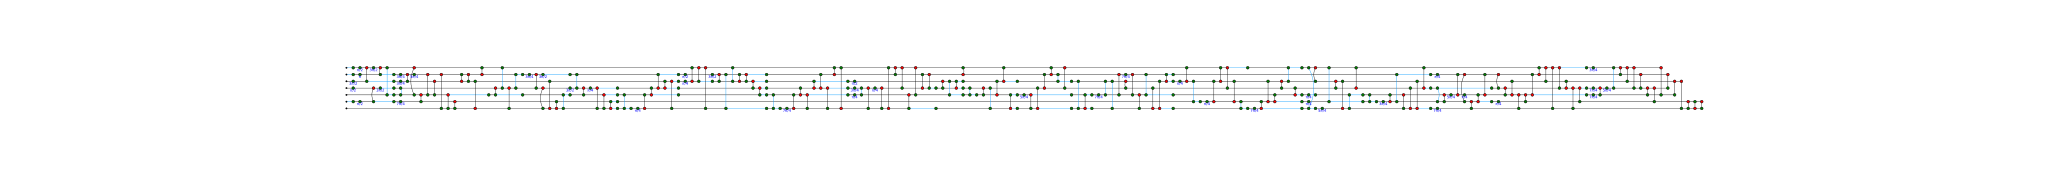

In [17]:
zx.draw(c4,figsize=(60,5),rows=(0,200))

Circuit  on 48 qubits with 14392 gates.
        1040 T-like gates
        13352 Cliffords among which 
        13216 2-qubit gates and 102 Hadamard gates.
Circuit  on 48 qubits with 13692 gates.
        1040 T-like gates
        12652 Cliffords among which 
        8360 2-qubit gates and 4258 Hadamard gates.

 ncalls  tottime  percall  cumtime  percall filename:lineno(function)
 476295    2.563    0.000    2.563    0.000 linalg.py:53(row_add)
     44    0.751    0.017   14.162    0.322 linalg.py:262(find_minimal_sums)
  53277    2.330    0.000    2.350    0.000 linalg.py:63(col_add)

In [36]:
list(zip([1,2,3],[2,3,4]))

[(1, 2), (2, 3), (3, 4)]

In [32]:
%timeit 0 if v else 1

31.9 ns ± 0.486 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


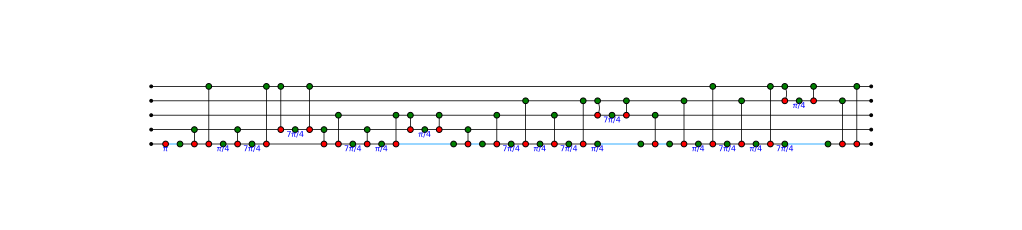

In [13]:
zx.draw(g2,figsize=(14,3))

In [14]:
zx.compare_tensors(g2.to_tensor(),c3.to_graph().to_tensor())

True

In [12]:
print(c2.gates[-100:])

[ParityPhase(1/4, 19, 20, 17, 18, 23), ParityPhase(5/4, 19, 20, 17), HAD(19), ZPhase(19,phase=3/4), HAD(23), ZPhase(23,phase=7/4), CZ(19,20), CZ(23,16), CZ(23,18), HAD(16), ZPhase(16,phase=7/4), CZ(23,16), ParityPhase(7/4, 22, 14, 19), ParityPhase(1/4, 14, 23), ParityPhase(7/4, 19, 14, 17, 22), ParityPhase(7/4, 17, 19), ParityPhase(1/4, 16, 14), ParityPhase(7/4, 16, 23), HAD(19), CZ(17,19), CZ(19,13), CZ(19,20), HAD(13), ZPhase(13,phase=7/4), CZ(20,13), CZ(17,13), ParityPhase(1/4, 18, 22, 14, 13), ParityPhase(7/4, 14, 22, 13), ParityPhase(1/4, 18, 13), HAD(13), HAD(22), CZ(13,17), CZ(13,20), CZ(22,14), CZ(22,18), HAD(20), ZPhase(20,phase=1), CZ(20,17), HAD(17), CZ(17,13), CNOT(18,15), HAD(18), ZPhase(18,phase=1), CNOT(14,21), CNOT(23,14), HAD(23), CZ(23,16), HAD(16), ZPhase(16,phase=1/4), CZ(16,14), CZ(16,15), HAD(15), ZPhase(15,phase=1/4), CZ(16,15), ParityPhase(5/4, 21, 16), ParityPhase(5/4, 21, 15), HAD(15), CZ(15,16), HAD(16), ZPhase(16,phase=1), CZ(23,16), CZ(16,14), CZ(16,21), HA

In [7]:
c3, blocks = circuit_phase_polynomial_blocks(c2.to_basic_gates(),optimize=True)
print(c3.stats())

Circuit  on 19 qubits with 1225 gates.
        100 T-like gates
        1125 Cliffords among which 
        819 2-qubit gates and 296 Hadamard gates.


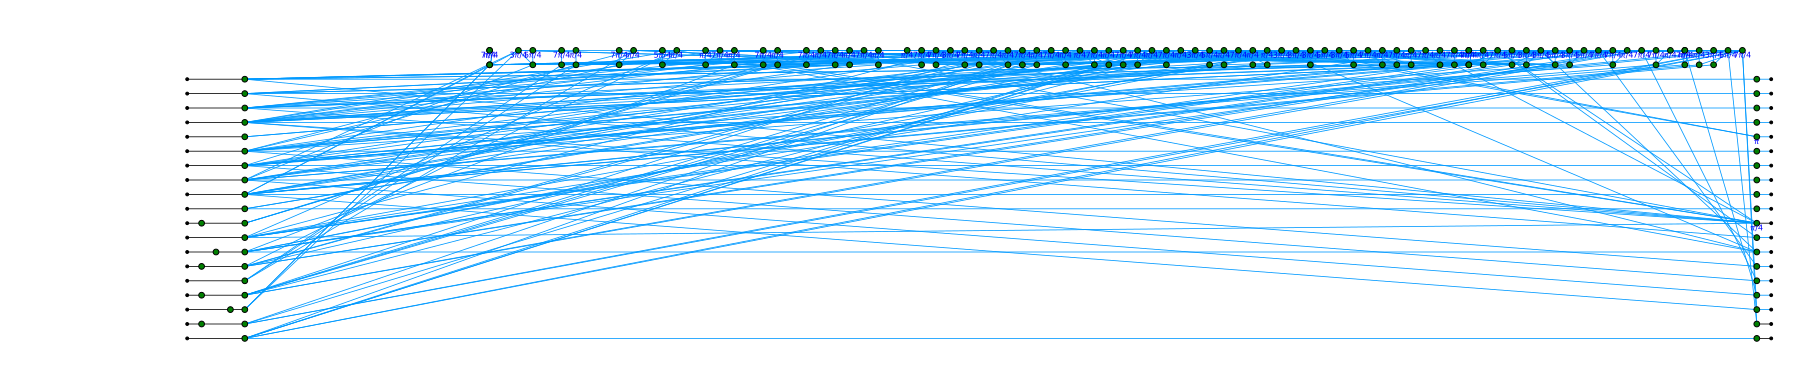

In [6]:
zx.draw(g,figsize=(25,5))

True


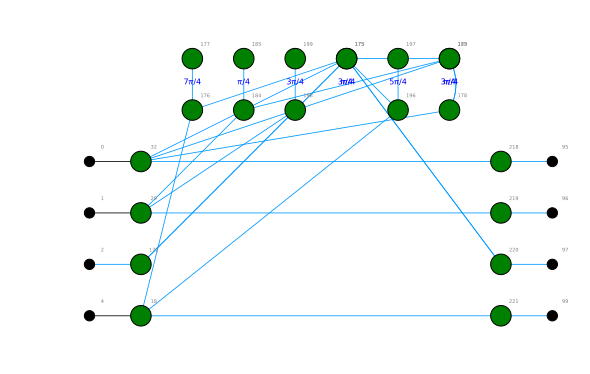

In [94]:
g2 = g.copy()
etab, rem_verts, rem_edges, check_isolated_vertices = zx.rules.pivot(g,[(10,172,[2],[])])
g.add_edge_table(etab)
g.remove_edges(rem_edges)
g.remove_vertices(rem_verts)
g.normalise()
print(zx.compare_tensors(g2.to_tensor(),g.to_tensor()))
zx.draw(g, labels=True, figsize=(8,5))

In [31]:
leftrow = 4
left = [v for v in g.vertices() if g.row(v) == leftrow]
special_nodes = {}
for v in g.vertices():
    if len(list(g.neighbours(v))) == 1 and v not in g.inputs and v not in g.outputs:
        n = list(g.neighbours(v))[0]
        special_nodes[n] = v

right = set()
for v in left: right.update(w for w in g.neighbours(v) if g.row(w)>leftrow)
gadgets = right.intersection(special_nodes)
rightnogadget = right.difference(gadgets)
for gad in gadgets:
    n = right.difference({gad})
    leftplusgadget = left + [gad]
    n = n.union([w for w in g.neighbours(gad) if w not in left])
    n = n.difference({special_nodes[gad]})
    m = zx.extract.bi_adj(g, list(n), leftplusgadget)
    if m.rank() == 19:
        print(gad)
        break
x,y = m.factor()
print(x)
#print(w1, w2, w3, zx.extract.cut_rank(g, list(right.difference({w1,w2, w3})), left))
#zx.extract.cut_rank(g, right, left)

782
[ 0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  1  0 ]
[ 0  0  0  0  0  0  0  0  0  0  0  1  1  0  0  0  1  1  0 ]
[ 0  0  0  0  0  0  1  1  0  0  0  1  1  0  0  0  1  1  0 ]
[ 0  0  0  0  0  0  0  1  0  0  0  1  1  0  0  0  1  1  0 ]
[ 1  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  1  0 ]
[ 0  0  0  0  1  0  0  0  0  0  1  0  0  0  0  0  0  1  0 ]
[ 1  0  0  1  0  0  0  1  0  0  0  1  1  0  0  0  1  1  0 ]
[ 0  1  0  0  0  0  0  0  0  0  0  1  1  0  0  0  1  1  0 ]
[ 0  0  1  0  0  0  1  1  0  0  0  1  1  0  0  0  1  1  0 ]
[ 0  0  1  0  0  0  1  1  0  1  0  1  1  0  0  0  1  1  0 ]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0 ]
[ 0  0  1  0  0  0  1  1  0  0  0  1  0  0  0  0  0  0  0 ]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  0 ]
[ 0  0  0  0  0  0  1  0  1  0  0  0  0  0  0  0  0  0  0 ]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  1  1  0 ]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  1  1  0 ]
[ 0  0  0  0  0  1  0  0  0  0  1  0

In [ ]:
g2 = g.copy()
#zx.simplify.id_simp(g2,quiet=True)
g4 = zx.quantomatic.edit_graph(g2)

Opening Quantomatic...


In [69]:
t = g.to_tensor()
t/t.flatten()[0]

array([[[[[[[[ 1.+0.j,  0.+0.j],
             [ 0.+0.j, -1.+0.j]],

            [[ 0.+0.j,  0.+0.j],
             [ 0.+0.j,  0.+0.j]]],


           [[[ 0.+0.j,  0.+0.j],
             [ 0.+0.j,  0.+0.j]],

            [[ 1.-0.j,  0.+0.j],
             [ 0.+0.j,  0.+1.j]]]],



          [[[[ 0.+0.j,  0.+0.j],
             [ 0.+0.j,  0.+0.j]],

            [[ 0.+0.j,  0.+0.j],
             [ 0.+0.j,  0.+0.j]]],


           [[[ 0.+0.j,  0.+0.j],
             [ 0.+0.j,  0.+0.j]],

            [[ 0.+0.j,  0.+0.j],
             [ 0.+0.j,  0.+0.j]]]]],




         [[[[[ 0.+0.j,  0.+0.j],
             [ 0.+0.j,  0.+0.j]],

            [[ 0.+0.j,  0.+0.j],
             [ 0.+0.j,  0.+0.j]]],


           [[[ 0.+0.j,  0.+0.j],
             [ 0.+0.j,  0.+0.j]],

            [[ 0.+0.j,  0.+0.j],
             [ 0.+0.j,  0.+0.j]]]],



          [[[[-1.+0.j,  0.+0.j],
             [ 0.+0.j,  1.-0.j]],

            [[ 0.+0.j,  0.+0.j],
             [ 0.+0.j,  0.+0.j]]],


           [[[ 0.+0.j,  0.